# Approximate Inference with Sampling

**COMP9418-19T3, W10 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Last Update 12th November at 18:00, 2020

In this week's tutorial, we will implement the four sampling algorithms discussed in the lecture. We will also investigate the performance of these algorithms in terms of running time and accuracy for answering marginal and conditional probabilistic queries.

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default [full installation](https://conda.io/docs/install/full.html), these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management, you may need to run this command:

```python
pip3 install matplotlib
```

To render a visualization of some graphical models, you also need to install Graphviz [download page](http://www.graphviz.org/download). We have already used this library in Tutorial 1, thus, you should have it installed.

Once we have done all that, we import some useful modules for later use.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# combinatorics
from itertools import product, combinations, permutations
# ordered dictionaries are useful for keeping ordered sets of varibles
from collections import OrderedDict as odict
# visualise graphs
from graphviz import Digraph
# visualise plots
import matplotlib.pyplot as plt
# table formating for screen output
from tabulate import tabulate
# random number generator library
import random
# access to math.inf
import math

## The ICU network

Once again, we will use the ICU-Alarm network as a benchmark. You should remember this Bayesian Network from Week 3 Tutorial. It is a subset of nine nodes from a [larger network](https://www.bnlearn.com/bnrepository/discrete-medium.html#alarm) of 37 nodes.

The following image is a graphical representation of a subset of nine nodes we will use in this tutorial.

![ICU Graph](img/ICU_graph.png "Graph exercise")

Once again, we will use a dictionary to store the factors in the network. We call this dictionary `ICU_factors`. In the next cell, we will load this dictionary as well as the outcome space `ICU_outcomespace` and the Bayesian network graph called `ICU_graph`. 

In [2]:
ICU_factors = {
    'H': {
        'dom': ('H',), 
        'table': odict([
            ((0,), 0.80),
            ((1,), 0.20),
        ])
    },
    
    'V': {
        'dom': ('L', 'H', 'V'), 
        'table': odict([
            ((0, 0, 0), 0.05),
            ((0, 0, 1), 0.95),
            ((0, 1, 0), 0.99),
            ((0, 1, 1), 0.01),
            ((1, 0, 0), .1),
            ((1, 0, 1), .9),
            ((1, 1, 0), .9),
            ((1, 1, 1), .1),
        ])
    },

    'C' : {
        'dom': ('V', 'C'), 
        'table': odict([
            ((0, 0), 0.94),
            ((0, 1), 0.04),
            ((0, 2), 0.02),
            ((1, 0), 0.02),
            ((1, 1), 0.26),
            ((1, 2), 0.72),
        ])
    },

    'L' : {
        'dom': ('L',), 
        'table': odict([
            ((0, ), 0.95),
            ((1, ), 0.05),
        ])
    },

    'S' : {
        'dom': ('L', 'H', 'S'), 
        'table': odict([
            ((0, 0, 0), 0.04),
            ((0, 0, 1), 0.96),
            ((0, 1, 0), 0.48),
            ((0, 1, 1), 0.52),
            ((1, 0, 0), 0.95),
            ((1, 0, 1), 0.05),
            ((1, 1, 0), .1),
            ((1, 1, 1), .9),
        ])
    },

    'O' : {
        'dom': ('S', 'V', 'O'), 
        'table': odict([
            ((0, 0, 0), 0.97),
            ((0, 0, 1), 0.01),
            ((0, 0, 2), 0.02),
            ((0, 1, 0), 0.78),
            ((0, 1, 1), 0.19),
            ((0, 1, 2), 0.03),
            ((1, 0, 0), 0.22),
            ((1, 0, 1), 0.76),
            ((1, 0, 2), 0.02),
            ((1, 1, 0), 0.01),
            ((1, 1, 1), 0.01),
            ((1, 1, 2), 0.98),        
        ])
    },

    'T': {
        'dom': ('A', 'T'), 
        'table': odict([
            ((0, 0), 0.30),
            ((0, 1), 0.70),
            ((1, 0), .9),
            ((1, 1), .1),
        ])
    },

    'B' : {
        'dom': ('O', 'T', 'B'), 
        'table': odict([
            ((0, 0, 0), .9),
            ((0, 0, 1), .05),
            ((0, 0, 2), .05),
            ((0, 1, 0), 0.30),
            ((0, 1, 1), 0.62),
            ((0, 1, 2), 0.08),
            ((1, 0, 0), 0.93),
            ((1, 0, 1), 0.06),
            ((1, 0, 2), .01),
            ((1, 1, 0), 0.02),
            ((1, 1, 1), 0.49),
            ((1, 1, 2), 0.49),
            ((2, 0, 0), 0.90),
            ((2, 0, 1), 0.08),
            ((2, 0, 2), 0.02),
            ((2, 1, 0), 0.01),
            ((2, 1, 1), 0.08),
            ((2, 1, 2), 0.91),        
        ])
    },

    'A' : {
        'dom': ('A',), 
        'table': odict([
            ((0, ), 0.99),
            ((1, ), 0.01),
        ])
    }
}

ICU_outcomespace = dict(
    H=(0,1),
    L=(0,1),
    A=(0,1),
    V=(0,1),
    S=(0,1),
    T=(0,1),
    C=(0,1,2),
    O=(0,1,2),
    B=(0,1,2),
)

ICU_graph = {
    'L': ['S', 'V'],
    'H': ['S', 'V'],
    'S': ['O'],
    'V': ['C', 'O'],
    'O': ['B'],
    'A': ['T'],
    'T': ['B'],
    'C': [],
    'B': [],
}

We will use variable elimination to compute the answer to several queries. In the next cell, we will load seven functions from previous tutorials that implement the VE algorithm. These functions are:

- `prob`
- `marginalize`
- `join`
- `interactionGraph`
- `mindegree`
- `normalize`
- `query`

In [3]:
def prob(factor, *entry):
    """
    argument 
    `factor`, a dictionary of domain and probability values,
    `entry`, a list of values, one for each variable in the same order as specified in the factor domain.
    
    Returns p(entry)
    """

    return factor['table'][entry]     # insert your code here, 1 line   

def marginalize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be summed out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """

    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove().
    table = list()                 # Create an empty list for table. We will fill in table from scratch.
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;                     # Initialize the summation variable s. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)
            
            p = prob(f, *tuple(entriesList))     # Calculate the probability of factor f for entriesList.
            s = s + p                            # Sum over all values of var by accumulating the sum in s.
            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}

def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    
    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()
    
    # Here is where the magic happens. The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        # Insert your code here
        p1 = prob(f1, *f1_entry)           # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry 
        p2 = prob(f2, *f2_entry)           # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry 
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
        
    return {'dom': tuple(common_vars), 'table': odict(table)}

def VE(factors, order, outcomeSpace):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `order`, a list of variable names specifying an elimination order,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns a dictionary with non-eliminated factors
    """    

    # Let's make a copy of factors, so we can freely modify it without distroying the original dictionary
    f = factors.copy()
    # We process the factor in elimination order  
    for i, var in enumerate(order):
        # This is the domain of the new factor. We use sets as it is handy to eliminate duplicate variables
        newFactorDom = set()
        # This is a list of factors that will be removed from f because they were joined with other factors
        listFactorsRemove = list()
        # This is a flag to indicate if we are processing the first factor
        first = True
        # Lets iterate over all factors
        for f_id in f.keys():
            # and select the ones that have the variable to be eliminated
            if var in f[f_id]['dom']:        
                if first:
                    # We need this code since join requires two factors, so we save the first one in fx and wait for the next
                    fx = f[f_id]
                    first = False
                else:
                    # Join fx and f[f_id] and save the result in fx
                    fx = join(fx, f[f_id], outcomeSpace)
                # f_id was joined, so we will need to eliminate it from f later. Let's save that factor id for future removal
                listFactorsRemove.append(f_id)
        # Now, we need to remove var from the domain of the new factor doing a marginalization              
        fx = marginalize(fx, var, outcomeSpace)
        # Now, we remove all factors that we joined. We do it outside the for loop since it modifies the data structure
        for f_id in listFactorsRemove:
            del f[f_id]
        # We will create a new factor with id equal a sequential number and insert it into f, so it can be used in future joins          
        f[i] = fx
    return f

def interactionGraph(factors, outcomeSpace):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns an adjacency list representation of the induced graph
    """        
    # Initialize representation that is a dictionary of node ids
    ig = {}
    # Initialize each adjacency list with an empty list
    for var in outcomeSpace.keys():
        ig[var] = []
    for f_id in factors.keys():
        for var1 in factors[f_id]['dom']:
            for var2 in factors[f_id]['dom']:
                if var1 != var2 and var2 not in ig[var1]:
                    # Connect node var1 with var2 by adding var2 in the adjaceny list of var1
                    ig[var1].append(var2)
    return ig

def minDegree(igGraph):
    """
    argument 
    `ig`, an induced graph,
    Returns a elimination order according to the min-degree heuristic
    """      
    # Initialize order with empty list. This variable will have the answer in the end of the execution
    order = []
    # Let's make a copy of iGraph to guarantee we will not destroy it
    ig = igGraph.copy()
    # While the induced graph has nodes to be eliminated
    while ig:
        # Initialize minDegree with a large number: math.inf
        minDegree = math.inf
        for var in ig.keys():
            # Test if var has a degree smaller than minDegree
            if len(ig[var]) < minDegree:
                # We have found a new candidate to be the next eliminated variable. Let's save its degree and name
                minDegree = len(ig[var])
                minVar = var
        # We need to connected the neighbours of minVar, let us start using combinations function to find all pairs of minVar's neighbours
        for neigh in combinations(ig[minVar], 2):
            # We need to check if these neighbour are not already connected by an edge
            if not neigh[0] in ig[neigh[1]]:
                # Now, let's connected them. Remember, this is an undirected graph, so we need two edges
                ig[neigh[0]].append(neigh[1])
                ig[neigh[1]].append(neigh[0])
        # Insert in order the variable in minVar
        order.append(minVar)
        # Now, we need to remove minVar from the adjacency list of every node
        for var in ig.keys():
            if minVar in ig[var]:
                ig[var].remove(minVar)
        # As well as remove minVar adjacency list from the interaction graph
        del ig[minVar]
    return order

def evidence(var, e, outcomeSpace):
    """
    argument 
    `var`, a valid variable identifier.
    `e`, the observed value for var.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns dictionary with a copy of outcomeSpace with var = e
    """    
    newOutcomeSpace = outcomeSpace.copy()      # Make a copy of outcomeSpace with a copy to method copy(). 1 line
    newOutcomeSpace[var] = (e,)                # Replace the domain of variable var with a tuple with a single element e. 1 line
    return newOutcomeSpace

def normalize(f):
    """
    argument 
    `f`, factor to be normalized.
    
    Returns a new factor f' as a copy of f with entries that sum up to 1
    """ 
    table = list()
    sum = 0
    for k, p in f['table'].items():
        sum = sum + p
    for k, p in f['table'].items():
        if (sum == 0):
            table.append((k, p))
        else:
            table.append((k, p/sum))
    return {'dom': f['dom'], 'table': odict(table)}

def query(factors, order, outcomeSpace, q_vars, **q_evi):
    """
    argument 
    `factors`, a dictionary of factors
    `order`, a list with variable elimination order
    `outcomeSpace`, dictionary will variable domains
    `q_vars`, list of variables in query head
    `q_evi`, dictionary of evidence in the form of variables names and values
    
    Returns a new factor with P(Q, e) or P(Q|e)
    """     
    
    # Let's make a copy of these structures, since we will reuse the variable names
    outSpace = outcomeSpace.copy()
    o = order.copy()
    
    # First, we set the evidence 
    for var_evi, e in q_evi.items():
        outSpace = evidence(var_evi, e, outSpace)
        
    for q_var in q_vars:
        o.remove(q_var)
 
    f = VE(factors, o, outSpace)
    
    first = True
    for f_id in f.keys():
        if first:
            # We need this code since join requires two factors, so we save the first one in fx and wait for the next
            fx = f[f_id]
            first = False
        else:
            # Join fx and f[f_id] and save the result in fx
            fx = join(fx, f[f_id], outSpace)    
    
    return normalize(fx)

## Topological Sort

The sampling methods for Bayesian networks use the topological sort algorithm to determine the order to sample the network nodes.

In the next cell, we revisit the code we developed in Week 1 tutorial. We will make the code more robust by calling the topological sort recursive algorithm multiple times to guarantee we will visit all nodes. We proposed such an improvement as exercise at the end of that tutorial.

### Exercise

Develop a topological sort function that returns the topological order for an arbitrary Bayesian network. We will test the code in the ICU network.

In [4]:
# This is the recursive function that visits the nodes according to depth-first search and appends the black nodes 
# to the end of a `stack` list.
def topologicalSort_r(G, v, colour, stack):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `v`, current vertex
    `colour`, colouring dictionary
    `stack`, list with topological ordering of nodes
    """
    # Nodes are colored 'white', 'grey' and 'black'. When we first visit a node, we color ir as `grey`.
    colour[v] = None                                                                      # 1 line
    # Let's look at all nodes that are adjacent to node v
    for w in G[v]:
        # If the node color is 'white', it was never visited, so we call this function recursivelly to visit node w
        if colour[w] == None                                                              # 1 line
            # This is the recursive call to topologicalSort_r
            None                                                                          # 1 line
    # All adjacent nodes have been visited recursively. Now it is time to color the node as 'black'        
    colour[v] = None                                                                      # 1 line
    # Black nodes are appended to the `stack` list.
    stack.append(None)                                                                    # 1 line

# This is main function that prepares for the recursive function. It first colours all nodes as 'white' and call the
# recursive function for an arbitrary node. When the recursive function returns, if we have any remaining 'white'
# nodes, we call the recursive function again for these nodes.
def topologicalSort(G):
    """
    argument 
    `G`, an adjacency list representation of a graph
    return a list with the topological order of the graph G
    """
    # We start with an empty stack
    stack = None                                                                         # 1 line
    # Colour is dictionary that associates node keys to colours. The colours are 'white', 'grey' and 'black'.
    colour = {node: 'white' for node in G.keys()}
    # We call the recursive function to visit a first node. When the function returns, if there are any white 
    # nodes remaining, we call the function again for these white nodes
    for start in G.keys():
        # If the node is 'white' we call the recursive function to vists the nodes connected to it in DFS order
        if colour[start] == None:                                                        # 1 line
            # This is a call to topologicalSort_r
            None                                                                         # 1 line
    # We need to reverse the list, we use a little trick with list slicing
    return stack[::-1]


###################
# Test code

order = topologicalSort(ICU_graph)
print(order)

SyntaxError: invalid syntax (<ipython-input-4-6e6d4d05d150>, line 16)

In [5]:
# Answer

# This is the recursive function that visits the nodes according to depth-first search and appends the black nodes 
# to the end of a `stack` list.
def topologicalSort_r(G, v, colour, stack):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `v`, current vertex
    `colour`, colouring dictionary
    `stack`, list with topological ordering of nodes
    """
    # Nodes are colored 'white', 'grey' and 'black'. When we first visit a node, we color ir as `grey`.
    colour[v] = 'grey'                                                                    # 1 line
    # Let's look at all nodes that are adjacent to node v
    for w in G[v]:
        # If the node color is 'white', it was never visited, so we call this function recursivelly to visit node w
        if colour[w] == 'white':
            # This is the recursive call to topologicalSort_r
            topologicalSort_r(G, w, colour, stack)                                        # 1 line
    # All adjacent nodes have been visited recursively. Now it is time to color the node as 'black'        
    colour[v] = 'black'
    # Black nodes are appended to the `stack` list.
    stack.append(v)

# This is main function that prepares for the recursive function. It first colours all nodes as 'white' and call the
# recursive function for an arbitrary node. When the recursive function returns, if we have any remaining 'white'
# nodes, we call the recursive function again for these nodes.
def topologicalSort(G):
    """
    argument 
    `G`, an adjacency list representation of a graph
    return a list with the topological order of the graph G
    """
    # We start with an empty stack
    stack = []
    # Colour is dictionary that associates node keys to colours. The colours are 'white', 'grey' and 'black'.
    colour = {node: 'white' for node in G.keys()}
    # We call the recursive function to visit a first node. When the function returns, if there are any white 
    # nodes remaining, we call the function again for these white nodes
    for start in G.keys():
        # If the node is 'white' we call the recursive function to vists the nodes connected to it in DFS order
        if colour[start] == 'white':
            # This is a call to topologicalSort_r
            topologicalSort_r(G, start, colour, stack)
    # We need to reverse the list, we use a little trick with list slice
    return stack[::-1]


###################
# Test code

order = topologicalSort(ICU_graph)
print(order)

['A', 'T', 'H', 'L', 'V', 'C', 'S', 'O', 'B']


If your code is correct, you should see the following output:

```
['A', 'T', 'H', 'L', 'V', 'C', 'S', 'O', 'B']
``` 

# Sample a Bayesian network variable

Now, we will develop a simple function to sample one variable $X$ according to $P(X|\textbf{u})$, being $\textbf{u}$ a complete assignment for the variables $\textbf{U}$ that are the parents of $X$.

For now on, we will use the same notation as the lecture slides. In particular, the variable sigma ($\Sigma$) represents the assignment being sampled (variable by variable) from the Bayesian network. Each time we sample a value $x$ to a variable $X$, we add the entry `X:x` to the dictionary sigma.

## Exercise

Let's implement the function `sample_variable` that samples a variable $X$ according to $P(X|\textbf{u})$.

In [6]:
## Answer

def sample_variable(var, factor, sigma, outcomeSpace):
    """
    argument
    `var`: variable to be sampled according to P(var|parents(var))
    `factor`: factor that stores P(var|parents(var))
    `sigma`: a dictionary with the assigments to the network variables. We assume all parents of var are already assigned to a value
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: modify sigma to include var:value where value is sampled according to P(var|parents(var))
    """
    # Sample a value in the interval [0,1) using random()
    r = random.random()
    # s has the accumulative probabilities of P(var|parents(var))
    s = 0
    # Let's iterate over all valid var values and check which one was sampled
    for v in outcomeSpace[var]:
        # Assign the value in v to sigma
        sigma[var] = v
        # Let's prepare to call entry by creating a list with the values of var and its parents in same order of the variables in 'dom'
        entry = (sigma[var] for var in factor['dom'])
        # Add to s the probability specified by the assignment *entry
        s += prob(factor, *entry)
        # If we have achived a s value higher than s so v is the sampled value. Let's return with sigma modified with var = v
        if r < s:
            return sigma
        

#################
# Test code

random.seed(0)
sigma = {'A': 0}
zero = 0
one = 0
for i in range(1000):
    sigma = sample_variable('T', ICU_factors['T'], sigma , ICU_outcomespace)
    if sigma['T'] == 0:
        zero += 1
    else:
        one += 1
print("P(T=0|A=0)=",zero/(one+zero))
print("P(T=1|A=0)=",one/(one+zero))

P(T=0|A=0)= 0.296
P(T=1|A=0)= 0.704


If your code is correct, you should see the following output:

```
P(T=0|A=0)= 0.296
P(T=1|A=0)= 0.704
```

Compare these numbers obtained with 1000 samples with the true probabilities in the factor $P(T|A)$.

# Simulate a Bayesian network

Let's implement a procedure that simulates the Bayesian network. The simulation is the process that visits the network nodes in topological order and samples each node. At the end of the simulation, we will have a complete instantiation of the network variables.

## Exercise

Let's implement the function `simulate_BN`. We will need the `topologicalSort` and `sample_variable` functions implemented before.

In [7]:
def simulate_BN(G, factors, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: `sigma`: a dictionary with a complete assigment with all network variables
    """
    # Compute the topological order of G and assign the order to `pi`
    pi = None                                                                          # 1 line
    # Initialize `sigma` with an empty dictionary
    sigma = None                                                                       # 1 line
    # Let's iterate over all variables according to the order pi
    for var in pi:
        # Call `sample_variable` to sample variable `var`, modifying the `sigma` assignment
        None                                                                           # 1 line
    return sigma

####################
# Test code

random.seed(0)
print(simulate_BN(ICU_graph, ICU_factors, ICU_outcomespace))

TypeError: 'NoneType' object is not iterable

In [7]:
# Answer

def simulate_BN(G, factors, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: `sigma`: a dictionary with a complete assigment with all network variables
    """
    # Compute the topological order of G and assign the order to `pi`
    pi = topologicalSort(G)
    # Initialize `sigma` with an empty dictionary
    sigma = {}
    # Let's iterate over all variables according to the order pi
    for var in pi:
        # Call `sample_variable` to sample variable `var`, modifying the `sigma` assignment
        sigma = sample_variable(var, factors[var], sigma, outcomeSpace)
    return sigma

####################
# Test code

random.seed(0)
print(simulate_BN(ICU_graph, ICU_factors, ICU_outcomespace))

{'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}


If your code is correct, you should see the following output:

```
{'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}
```

This is one complete assignment sampled according to the underlying probability distribution specified by the Bayesian network. 

Let's now implement forward sampling to compute answers to prior marginal queries.

# Forward sampling

Forward sampling is a straightforward sampling procedure to compute prior marginal queries. Prior marginal queries are queries that do not involve evidence. Therefore, they are in the form $P(\alpha)$ where $alpha$ is an assignment to one or more variables.

In our implementation, we will specify a dictionary `alpha` that maps variables to values. For instance, if `alpha = {'A': 0})`, it means we want to compute $P(A=0)$. Similarly, if `alpha = {'A': 0, 'B': 1})`, we want to know $P(A=0,B=1)$. In addition, we will need to specify `n_samples` that is the number of samples used to estimate the probabilities.

## Exercise

Complete the implementation of `forward_sampling` function. 

In [11]:
def forward_sampling(G, factors, alpha, n_samples, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `alpha`: a dictionary maping variables to values
    `n_samples`: number of samples used to compute the probabilities
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: P(alpha)
    """
    # Initialise p. The varialbe p counts the number of samples that agree with alpha
    p = None                                                                          # 1 line
    for i in range(n_samples):
        # Call simulare_BN to obtain a new assigment according to P(X)
        s = None                                                                      # 1 line
        # Let's test if alpha matches s. If it does, increment the count p
        if (all(v == s[k] for k, v in alpha.items())):
            p += None                                                                 # 1 line
    return p/n_samples


#####################
# Test code

random.seed(0)
p = forward_sampling(ICU_graph, ICU_factors, {'A':0}, 100, ICU_outcomespace)
print("P(A=0)", p)

TypeError: 'NoneType' object is not subscriptable

In [8]:
# Answer

def forward_sampling(G, factors, alpha, n_samples, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `alpha`: a dictionary maping variables to values
    `n_samples`: number of samples used to compute the probabilities
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: P(alpha)
    """
    # Initialise p. The varialbe p counts the number of samples that agree with alpha
    p = 0
    for i in range(n_samples):
        # Call simulare_BN to obtain a new assigment according to P(X)
        s = simulate_BN(G, factors, outcomeSpace)
        # Let's test if alpha matches s. If it does, increment the count p
        if (all(v == s[k] for k, v in alpha.items())):
            p += 1
    return p/n_samples


#####################
# Test code

random.seed(0)
p = forward_sampling(ICU_graph, ICU_factors, {'A':0}, 100, ICU_outcomespace)
print("P(A=0)=", p)

P(A=0)= 0.99


If your code is correct, you should see the following output:

```
P(A=0)= 0.99
```

## Benchmarking with random queries

To benchmark our code, we need a large set of queries. As the forward sampling can only compute prior marginals, our queries need to be the form $P(\textbf{Q=q})$ where $\textbf{Q}$ are the query variables and $\textbf{q}$ are the corresponding values.

Next, we create a procedure that will create a set of random queries. We will use these queries to compare the sampling estimates to the true probabilities obtained with variable elimination.

First, let's take a look at a helper function that creates a random assignment with a maximum number of variables specified by `n_vars`.

In [9]:
# This is a helper function that creates an assignment (dictionary) with at most n_vars variables
def random_assignment(factors, outcomeSpace, n_vars, exclude = []):
    """
    argument
    `factors`: a dictionary will all netowrk factors
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    `n_vars`: maximum number of variables in the assignment
    `exclude`: list of variables names that cannot be included in the assignment
    return: dictionary representing an assignment with variables as keys and their corresponding values
    """    
    all_vars = [v for v in outcomeSpace.keys() if v not in exclude]
    rvars = random.sample(all_vars, random.randint(1, n_vars))
    return { v : random.choice(outcomeSpace[v]) for v in rvars}

################
# Test code

random.seed(0)
print(random_assignment(ICU_factors, ICU_outcomespace, 5))
print(random_assignment(ICU_factors, ICU_outcomespace, 3))
print(random_assignment(ICU_factors, ICU_outcomespace, 1))

{'C': 1, 'H': 1, 'A': 1, 'S': 1}
{'V': 1, 'A': 0}
{'S': 0}


Now, we will implement a function that answers the queries created by `random_assignment`. We will use the variable elimination algorithm.

## Exercise 

Implement the `query_generator_prior_marginal`. This function calls `random_assignment` to create prior marginal queries and answers those queries with the VE algorithm. The argument `n_queries` specifies the number of queries to be created and answered.

In [16]:
def query_generator_prior_marginal(n_queries, factors, outcomeSpace):
    """
    argument
    `n_queries`: number of queries to be created and answered
    `factors`: a dictionary will all netowrk factors
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: list of dictionaries with the query and associated probability exactly computed with the VE algorithm
    """
    # query_list starts as an empty list
    query_list = None                                                                      # 1 line
    # Compute the elimination order using the minDegree heuristic
    order = None                                                                           # 1 line
    for i in range(n_queries):
        # Assign to alpha a random assignment created by `random_assignment`. Use max of 3 variables in alpha
        alpha = random_assignment(ICU_factors, outcomeSpace, 3)
        # Compute the answer to alpha using VE' query function
        f = None                                                                           # 1 line
        # Prepare the entries to compute the probability
        entry = (alpha[v] for v in f['dom'])
        # Store the results in query_list
        query_list.append({'query': alpha, 'prob': prob(f, *entry)})
    return query_list


################
# Test code

random.seed(0)
results = query_generator_prior_marginal(10, ICU_factors, ICU_outcomespace)
for r in results:
    print("P(",r['query'],") =",r['prob'])

TypeError: 'NoneType' object is not subscriptable

In [10]:
# Answer

def query_generator_prior_marginal(n_queries, factors, outcomeSpace):
    """
    argument
    `n_queries`: number of queries to be created and answered
    `factors`: a dictionary will all netowrk factors
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: list of dictionaries with the query and associated probability exactly computed with the VE algorithm
    """
    # query_list starts as an empty list
    query_list = []
    # Compute the elimination order using the minDegree heuristic
    order = minDegree(interactionGraph(factors, outcomeSpace))
    for i in range(n_queries):
        # Assign to alpha a random assignment created by `random_assignment`
        alpha = random_assignment(ICU_factors, outcomeSpace, 3)
        # Compute the answer to alpha using VE' query function
        f = query(factors, order, outcomeSpace, alpha.keys())
        # Prepare the entries to compute the probability
        entry = (alpha[v] for v in f['dom'])
        # Store the results in query_list
        query_list.append({'query': alpha, 'prob': prob(f, *entry)})
    return query_list


################
# Test code

random.seed(0)
results = query_generator_prior_marginal(10, ICU_factors, ICU_outcomespace)
for r in results:
    print("P(",r['query'],") =",r['prob'])

P( {'C': 1, 'H': 1} ) = 0.008638
P( {'S': 1, 'O': 2} ) = 0.6857236800000002
P( {'B': 0} ) = 0.3210289226056
P( {'A': 1, 'L': 0} ) = 0.009500000000000001
P( {'L': 1, 'B': 1} ) = 0.01971616586
P( {'L': 1, 'T': 0, 'V': 1} ) = 0.011322000000000004
P( {'B': 0, 'S': 0} ) = 0.07445750776239998
P( {'C': 2} ) = 0.5526300000000001
P( {'H': 1, 'O': 0, 'C': 2} ) = 0.0028169927999999998
P( {'L': 0, 'V': 0} ) = 0.22609999999999997


If your code is correct, you should see the following output:

```
P( {'C': 1, 'H': 1} ) = 0.008638
P( {'S': 1, 'O': 2} ) = 0.6857236800000002
P( {'B': 0} ) = 0.3210289226056
P( {'A': 1, 'L': 0} ) = 0.009500000000000001
P( {'L': 1, 'B': 1} ) = 0.01971616586
P( {'L': 1, 'T': 0, 'V': 1} ) = 0.011322000000000004
P( {'B': 0, 'S': 0} ) = 0.07445750776239998
P( {'C': 2} ) = 0.5526300000000001
P( {'H': 1, 'O': 0, 'C': 2} ) = 0.0028169927999999998
P( {'L': 0, 'V': 0} ) = 0.22609999999999997
```

Now, we will use the developed functions to create 300 queries and answer them with VE and forward sampling. We will use a scatter plot to compare the results. We have developed some code in the next cell to do this task.

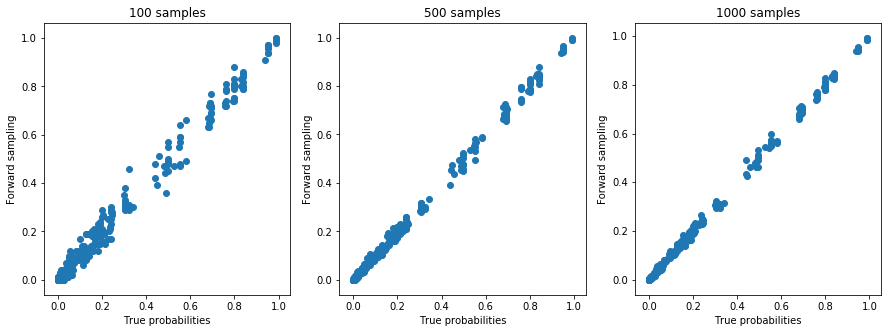

In [11]:
random.seed(0)
queries = query_generator_prior_marginal(300, ICU_factors, ICU_outcomespace)
x = [q['prob'] for q in queries]
y = [forward_sampling(ICU_graph, ICU_factors, q['query'], 100, ICU_outcomespace) for q in queries]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Forward sampling")
y = [forward_sampling(ICU_graph, ICU_factors, q['query'], 500, ICU_outcomespace) for q in queries]
plt.subplot(1,3,2)
plt.scatter(x, y)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Forward sampling")
y = [forward_sampling(ICU_graph, ICU_factors, q['query'], 1000, ICU_outcomespace) for q in queries]
plt.subplot(1,3,3)
plt.scatter(x, y)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Forward sampling")    
plt.show()

Great, we can see that forward sampling works quite well for unconditional queries. Let's take a look at the relative errors.

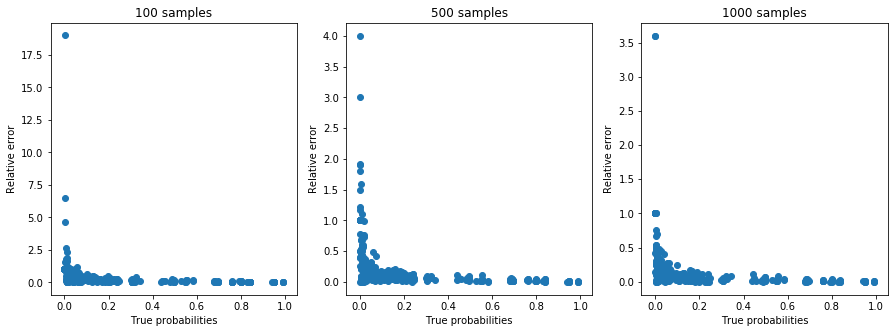

In [19]:
random.seed(0)
queries = query_generator_prior_marginal(300, ICU_factors, ICU_outcomespace)
x = [q['prob'] for q in queries]
y = [forward_sampling(ICU_graph, ICU_factors, q['query'], 100, ICU_outcomespace) for q in queries]
relative_error = [abs(x[i]-y[i])/x[i] for i in range(len(x)) if x[i] != 0]
probs = [p for p in x if p != 0]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(probs, relative_error)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Relative error")
y = [forward_sampling(ICU_graph, ICU_factors, q['query'], 500, ICU_outcomespace) for q in queries]
relative_error = [abs(x[i]-y[i])/x[i] for i in range(len(x)) if x[i] != 0]
plt.subplot(1,3,2)
plt.scatter(probs, relative_error)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Relative error")
y = [forward_sampling(ICU_graph, ICU_factors, q['query'], 1000, ICU_outcomespace) for q in queries]
relative_error = [abs(x[i]-y[i])/x[i] for i in range(len(x)) if x[i] != 0]
plt.subplot(1,3,3)
plt.scatter(probs, relative_error)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Relative error")
plt.show()

As we expected, the relative errors tend to be high for small probabilities, indicating that it is challenging to be relatively accurate in rare events. 

# Rejection sampling

Forward sampling is restricted to unconditional queries ($P(\textbf{Q})$). If we want to compute posterior marginals, we can make a straightforward adaptation. We reject all samples that do not match the evidence. This procedure is called rejection sampling.

The main difference between rejection and forward sampling is the simulation of the Bayesian network. With rejection sampling, we typically abort the simulation if we sample a value $x$ for an evidence variable $X \in \textbf{E}$ that do conform with the evidence $\textbf{e}$.

## Exercise

Let's start by implementing a function to simulate the network according to rejection sampling. The function `simulate_BN_rejection` has an argument `beta` that represents an assignment with the evidence. `beta` is a dictionary with the same format as `alpha`. Our objective will be to answer queries in the format $P(\alpha|\beta)$

In [22]:
# This procedure samples all variables in the Bayesian network. If we sample a value for a variable in beta and
# the sampled value does not match the assignment beta then we abort the simulation and return None
def simulate_BN_rejection(G, factors, beta, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: `sigma`: a dictionary with a complete assigment with all network variables respecting beta or None
    """
    # Call topologicalSort to provide an order to sample the network variables
    pi = None                                                                          # 1 line
    # Sigma is a dictionary that stores the assignment to be returned
    sigma = {}
    for var in pi:
        # Call sample_variable to sample var and modify sigma
        None                                                                           # 1 line
        # Test if the sampled value matches beta, if it does not abort and return None
        if var in beta.keys() and sigma[var] != beta[var]:
            return None # don't change this line
    return sigma


####################
# Test code

random.seed(0)
print(simulate_BN_rejection(ICU_graph, ICU_factors, {'A':0}, ICU_outcomespace))

TypeError: 'NoneType' object is not iterable

In [12]:
# Answer

# This procedure samples all variables in the Bayesian network. If we sample a value for a variable in beta and
# the sampled value does not match the assignment beta then we abort the simulation and return None
def simulate_BN_rejection(G, factors, beta, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: `sigma`: a dictionary with a complete assigment with all network variables respecting beta or None
    """
    # Call topologicalSort to provide an order to sample the network variables
    pi = topologicalSort(G)
    # Sigma is a dictionary that stores the assignment to be returned
    sigma = {}
    for var in pi:
        # Call sample_variable to sample var and modify sigma
        sigma = sample_variable(var, factors[var], sigma, outcomeSpace)
        # Test if the sampled value matches beta, if it does not abort and return None
        if var in beta.keys() and sigma[var] != beta[var]:
            return None
    return sigma


####################
# Test code

random.seed(0)
print(simulate_BN_rejection(ICU_graph, ICU_factors, {'A':0}, ICU_outcomespace))

{'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}


If your code is correct, you should see the following output:

```
{'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}
```

## Exercise

Let's complete the implementation of rejection sampling. The function `rejection_sampling` is very similar to `forward_sampling`. It will take `alpha` and `beta` assignments as input and return an estimate of $P(\alpha|\beta)$.

In [26]:
def rejection_sampling(G, factors, alpha, beta, n_samples, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `alpha`: a dictionary maping variables to values
    `beta`: a dictionary maping variables to values    
    `n_samples`: number of samples used to compute the probabilities
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: P(alpha|beta)
    """
    # p stores the number of samples that match alpha and beta
    p = 0
    # n stores the number of samples that match beta
    n = 0
    for i in range(n_samples):
        # Call simulate_BN_rejection to simulate the Bayesian network according to the rejection sampling procedure
        s = None                                                                          # 1 line
        # If the sample does not match beta than None is returned
        if s != None: # don't change this line                                                                    # Do not change this line
            # Check if the sample matches alpha
            if (all(v == s[k] for k, v in alpha.items())):
                p += 1
            n += 1
    # If P(beta) is small than we may end up with no samples matching beta. We need to avoid a division by zero here
    # This line may be a problem when p(beta) = 0 and p(alpha|beta) is undefined
    if (n == 0):
        return 0
    return p/n, n


#####################
# Test code

random.seed(0)
p, n = rejection_sampling(ICU_graph, ICU_factors, {'T':0}, {'A':0}, 1000, ICU_outcomespace)
print("P(A=0|T=0)=", p, "computed with", n, "samples")

TypeError: cannot unpack non-iterable int object

In [13]:
# Answer

def rejection_sampling(G, factors, alpha, beta, n_samples, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `alpha`: a dictionary maping variables to values
    `beta`: a dictionary maping variables to values    
    `n_samples`: number of samples used to compute the probabilities
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: P(alpha|beta)
    """
    # p stores the number of samples that match alpha and beta
    p = 0
    # n stores the number of samples that match beta
    n = 0
    for i in range(n_samples):
        # Call simulate_BN_rejection to simulate the Bayesian network according to the rejection sampling procedure
        s = simulate_BN_rejection(G, factors, beta, outcomeSpace)
        # If the sample does not match beta than None is returned
        if s != None:
            # Check if the sample matches alpha
            if (all(v == s[k] for k, v in alpha.items())):
                p += 1
            n += 1
    # If P(beta) is small than we may end up with no samples matching beta. We need to avoid a division by zero here
    # This line may be a problem when p(beta) = 0 and p(alpha|beta) is undefined
    if (n == 0):
        return 0, 0
    return p/n, n


#####################
# Test code

random.seed(0)
p, n = rejection_sampling(ICU_graph, ICU_factors, {'T':0}, {'A':0}, 1000, ICU_outcomespace)
print("P(A=0|T=0)=", p, "computed with", n, "samples")

P(A=0|T=0)= 0.3021148036253776 computed with 993 samples


If your code is correct, you should see the following output:

```
P(A=0|T=0)= 0.3021148036253776
```

Now, we can test the rejection sampling to see if it performs well for a large number of queries. We will create random queries as we did for the forward sampling.

## Exercise

Let's implement `query_generator_posterior_marginal` that will generate random queries with an alpha and beta parts.

In [28]:
def query_generator_posterior_marginal(n_queries, factors, outcomeSpace):
    """
    argument
    `n_queries`: number of queries to be created and answered
    `factors`: a dictionary will all netowrk factors
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: list of dictionaries with the query and associated probability exactly computed with the VE algorithm
    """
    # query_list starts as an empty list
    query_list = []
    # Compute the elimination order using the minDegree heuristic
    order = None                                                                                 # 1 line
    for i in range(n_queries):
        # Assign to alpha a random assignment created by `random_assignment`. Use max of 3 variables in alpha
        alpha = None                                                                             # 1 line
        # Assign to beta a random assignment created by `random_assignment` but exclude the variables in alpha. Use max of 3 variables in beta
        beta = None                                                                              # 1 line
        # Compute the answer to alpha given beta using VE query function
        f = None                                                                                 # 1 line
        # Prepare the entries to compute the probability
        entry = (alpha[v] for v in f['dom'])
        # Store the results in query_list
        query_list.append({'query': alpha, 'evidence': beta, 'prob': prob(f, *entry)})
    return query_list


################
# Test code

random.seed(0)
results = query_generator_posterior_marginal(10, ICU_factors, ICU_outcomespace)
for r in results:
    print("P(",r['query']," | ",r['evidence'],") =",r['prob'])

TypeError: 'NoneType' object is not subscriptable

In [14]:
# Answer

def query_generator_posterior_marginal(n_queries, factors, outcomeSpace):
    """
    argument
    `n_queries`: number of queries to be created and answered
    `factors`: a dictionary will all netowrk factors
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: list of dictionaries with the query and associated probability exactly computed with the VE algorithm
    """
    # query_list starts as an empty list
    query_list = []
    # Compute the elimination order using the minDegree heuristic
    order = minDegree(interactionGraph(factors, outcomeSpace))
    for i in range(n_queries):
        # Assign to alpha a random assignment created by `random_assignment`. Use max of 3 variables in alpha
        alpha = random_assignment(ICU_factors, outcomeSpace, 3)
        # Assign to beta a random assignment created by `random_assignment` but exclude the variables in alpha. Use max of 3 variables in beta
        beta = random_assignment(ICU_factors, outcomeSpace, 3, alpha.keys())
        # Compute the answer to alpha given beta using VE query function
        f = query(factors, order, outcomeSpace, alpha.keys(), **beta)
        # Prepare the entries to compute the probability
        entry = (alpha[v] for v in f['dom'])
        # Store the results in query_list
        query_list.append({'query': alpha, 'evidence': beta, 'prob': prob(f, *entry)})
    return query_list


################
# Test code

random.seed(0)
results = query_generator_posterior_marginal(10, ICU_factors, ICU_outcomespace)
for r in results:
    print("P(",r['query']," | ",r['evidence'],") =",r['prob'])

P( {'C': 1, 'H': 1}  |  {'B': 1, 'V': 1} ) = 0.0017515427949926759
P( {'V': 0, 'A': 0, 'O': 2}  |  {'C': 0, 'B': 1} ) = 0.0038999772774970264
P( {'L': 1}  |  {'A': 1, 'V': 1} ) = 0.048626626363516896
P( {'V': 1, 'O': 0, 'B': 2}  |  {'H': 1} ) = 0.00028619778399999993
P( {'H': 1, 'O': 0, 'C': 2}  |  {'B': 0, 'L': 0} ) = 0.004353998604346179
P( {'A': 1}  |  {'L': 1} ) = 0.01
P( {'O': 2, 'L': 1, 'A': 0}  |  {'S': 1, 'C': 1, 'V': 0} ) = 0.0011525190754039499
P( {'C': 0, 'T': 1, 'S': 0}  |  {'L': 0} ) = 0.0634793472
P( {'S': 0, 'O': 2, 'H': 0}  |  {'L': 0} ) = 0.000944
P( {'B': 2, 'C': 2, 'O': 1}  |  {'L': 1, 'T': 1, 'V': 1} ) = 0.06239792432432433


If your code is correct, you should see the following output:

```
P( {'C': 1, 'H': 1}  |  {'B': 1, 'V': 1} ) = 0.0017515427949926759
P( {'V': 0, 'A': 0, 'O': 2}  |  {'C': 0, 'B': 1} ) = 0.0038999772774970264
P( {'L': 1}  |  {'A': 1, 'V': 1} ) = 0.048626626363516896
P( {'V': 1, 'O': 0, 'B': 2}  |  {'H': 1} ) = 0.00028619778399999993
P( {'H': 1, 'O': 0, 'C': 2}  |  {'B': 0, 'L': 0} ) = 0.004353998604346179
P( {'A': 1}  |  {'L': 1} ) = 0.01
P( {'O': 2, 'L': 1, 'A': 0}  |  {'S': 1, 'C': 1, 'V': 0} ) = 0.0011525190754039499
P( {'C': 0, 'T': 1, 'S': 0}  |  {'L': 0} ) = 0.0634793472
P( {'S': 0, 'O': 2, 'H': 0}  |  {'L': 0} ) = 0.000944
P( {'B': 2, 'C': 2, 'O': 1}  |  {'L': 1, 'T': 1, 'V': 1} ) = 0.06239792432432433
```

Now, we can assess the performance of rejection sampling using a set of random queries. We will use 300 queries in total. The next cell computes the queries and plots the results for VE and rejection sampling.

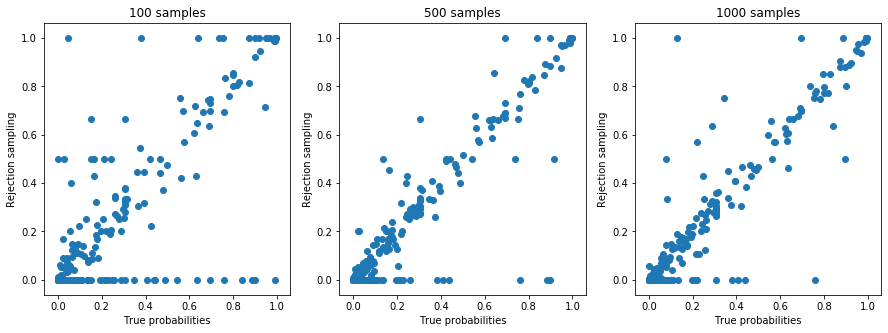

In [15]:
random.seed(0)
queries = query_generator_posterior_marginal(300, ICU_factors, ICU_outcomespace)
x = [q['prob'] for q in queries]
y = [rejection_sampling(ICU_graph, ICU_factors, q['query'], q['evidence'], 100, ICU_outcomespace)[0] for q in queries]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")
y = [rejection_sampling(ICU_graph, ICU_factors, q['query'], q['evidence'], 500, ICU_outcomespace)[0] for q in queries]
plt.subplot(1,3,2)
plt.scatter(x, y)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")
y = [rejection_sampling(ICU_graph, ICU_factors, q['query'], q['evidence'], 1000, ICU_outcomespace)[0] for q in queries]
plt.subplot(1,3,3)
plt.scatter(x, y)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")    
plt.show()

The results look much worse than the ones we obtained with forward sampling. This illustrates the issue we described in the lectures with the difficulty of sampling from distributions in the form $P(.|\beta)$. When $P(\beta)$ is small, we reject many samples, and we may end up with poor estimates.

Let's confirm this hypothesis. The next cell computes the same plot, but it associates the size of each point with the number of samples used to calculate the estimate.

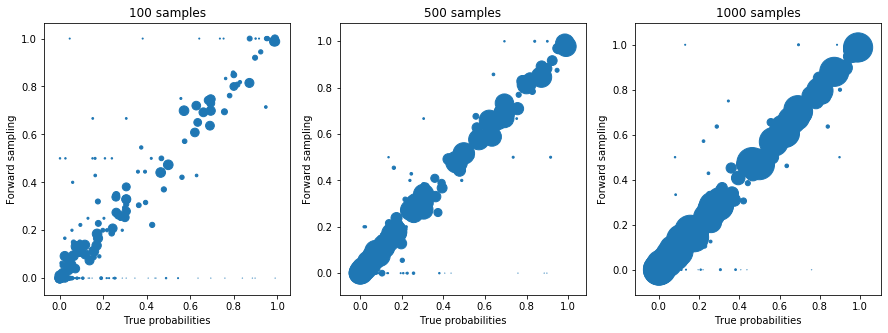

In [31]:
random.seed(0)
queries = query_generator_posterior_marginal(300, ICU_factors, ICU_outcomespace)
x = [q['prob'] for q in queries]
r = [rejection_sampling(ICU_graph, ICU_factors, q['query'], q['evidence'], 100, ICU_outcomespace) for q in queries]
y = [x[0] for x in r]
w = [x[1]+.1 for x in r]                                   # Don't let the zero weight estimates disapper in the plot
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y, s = w)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")
r = [rejection_sampling(ICU_graph, ICU_factors, q['query'], q['evidence'], 500, ICU_outcomespace) for q in queries]
y = [x[0] for x in r]
w = [x[1]+.1 for x in r]                                   # Don't let the zero weight estimates disapper in the plot
plt.subplot(1,3,2)
plt.scatter(x, y, s = w)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")
r = [rejection_sampling(ICU_graph, ICU_factors, q['query'], q['evidence'], 1000, ICU_outcomespace) for q in queries]
y = [x[0] for x in r]
w = [x[1]+.1 for x in r]                                   # Don't let the zero weight estimates disapper in the plot
plt.subplot(1,3,3)
plt.scatter(x, y, s = w)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Rejection sampling")    
plt.show()

Indeed, the poorest estimates are those associated with small sample sizes. Notice the several bad estimates returned zero probability, but the true probability was not zero. These are cases the probability of evidence was tiny, and we ended up with no samples.

# Likelihood weighting

Let's see if we can do better with likelihood weighting sampling. We need to start by creating a new procedure to simulate the Bayesian network and compute the weights.

The procedure is simple. We traverse the network in topological order. If the current node is an evidence variable, then we compute the weight associated with its likelihood. If the current node is not in the evidence set, we sample the variable related to the node.

## Exercise

Let's implement the function `simulate_BN_likelihood` that simulates the network and computes a sample and its corresponding weight.

In [32]:
def simulate_BN_likelihood(G, factors, beta, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: `sigma`, weight: a dictionary with a complete assigment with all network variables respecting beta and its corresponding weight
    """
    # Call topologicalSort to compute the order we will traverse the network
    pi = None                                                                               # 1 line
    # sigma is a complete assignment for all network variables. We start with an empty assignment
    sigma = None                                                                            # 1 line
    # This is the assignment weight. We start with one and change it for each observed variable
    w = None                                                                                # 1 line
    for var in pi:
        if var not in beta.keys():
            # For the variables NOT in the evidence (beta), we need to sample a value for the variable
            None                                                                            # 1 line
        else:
            # For the variables in the evidence (beta), we need to update the weight
            sigma[var] = beta[var]
            entry = (sigma[v] for v in factors[var]['dom'])
            w *= prob(factors[var], *entry)             
    return sigma, w


####################
# Test code

random.seed(0)
print(simulate_BN_likelihood(ICU_graph, ICU_factors, {'A':0}, ICU_outcomespace))

TypeError: 'NoneType' object is not iterable

In [16]:
# Answer

def simulate_BN_likelihood(G, factors, beta, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: `sigma`, weight: a dictionary with a complete assigment with all network variables respecting beta and its corresponding weight
    """
    # Call topologicalSort to compute the order we will traverse the network
    pi = topologicalSort(G)
    # sigma is a complete assignment for all network variables. We start with an empty assignment
    sigma = {}
    # This is the assignment weight. We start with one and change it for each observed variable
    w = 1
    for var in pi:
        if var not in beta.keys():
            # For the variables NOT in the evidence (beta), we need to sample a value for the variable
            sample_variable(var, factors[var], sigma, outcomeSpace)
        else:
            # For the variables in the evidence (beta), we need to update the weight
            sigma[var] = beta[var]
            entry = (sigma[v] for v in factors[var]['dom'])
            w *= prob(factors[var], *entry)
    return sigma, w


####################
# Test code

random.seed(0)
print(simulate_BN_likelihood(ICU_graph, ICU_factors, {'A':0}, ICU_outcomespace))

({'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}, 0.99)


If your code is correct, you should see the following output:

```
({'A': 0, 'T': 1, 'H': 0, 'L': 0, 'V': 1, 'C': 2, 'S': 1, 'O': 2, 'B': 2}, 0.99)
```

Now, we can implement the `likelihood_weighting` function. This subroutine samples the network by simulating it according to the `simulate_BN_likelihood` procedure. It will be very similar to the code we have developed for the forward and rejection sampling.

## Exercise

Let's implement the `likelihood_weighting` function that creates `n_samples` samples and estimates the probability according to those samples.

Notice that the samples now have weights and we must consider them when we compute the probabilities.

In [17]:
def likelihood_weighting(G, factors, alpha, beta, n_samples, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `alpha`: a dictionary maping variables to values
    `beta`: a dictionary maping variables to values    
    `n_samples`: number of samples used to compute the probabilities
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: P(alpha|beta)
    """
    # p stores the sum of weights of samples that match alpha and beta    
    p = 0
    # n stores the sum of weights of samples that match beta    
    n = 0
    for i in range(n_samples):
        # Call simulate_BN_likelihood to simulate the Bayesian network according to the likelihood weighting procedure        
        s, w = simulate_BN_likelihood(G, factors, beta, outcomeSpace)                                    # 1 line
        # Check if the sample matches alpha        
        if (all(v == s[k] for k, v in alpha.items())):
            p += w
        n += w
    # If P(beta) is small than we may end up with no samples matching beta. We need to avoid a division by zero here
    # This line may be a problem when p(beta) = 0 and p(alpha|beta) is undefined        
    if n == 0:
        return (0, 0)
    return p/n, n

#####################
# Test code

random.seed(0)
p, w = likelihood_weighting(ICU_graph, ICU_factors, {'T':0}, {'A':0}, 1000, ICU_outcomespace)
print("P(A=0|T=0)=", p, "computed with weight", w)

P(A=0|T=0)= 0.2879999999999989 computed with weight 990.0000000000076


In [35]:
# Answer

def likelihood_weighting(G, factors, alpha, beta, n_samples, outcomeSpace):
    """
    argument
    `G`: A adjacency list representation of the network structure
    `factors`: a dictionary will all netowrk factors
    `alpha`: a dictionary maping variables to values
    `beta`: a dictionary maping variables to values    
    `n_samples`: number of samples used to compute the probabilities
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: P(alpha|beta)
    """
    # p stores the sum of weights of samples that match alpha and beta    
    p = 0
    # n stores the sum of weights of samples that match beta    
    n = 0
    for i in range(n_samples):
        # Call simulate_BN_likelihood to simulate the Bayesian network according to the likelihood weighting procedure        
        s, w = simulate_BN_likelihood(G, factors, beta, outcomeSpace)
        # Check if the sample matches alpha        
        if (all(v == s[k] for k, v in alpha.items())):
            p += w
        n += w
    # If P(beta) is small than we may end up with no samples matching beta. We need to avoid a division by zero here
    # This line may be a problem when p(beta) = 0 and p(alpha|beta) is undefined        
    if n == 0:
        return (0, 0)
    return p/n, n

#####################
# Test code

random.seed(0)
p, w = likelihood_weighting(ICU_graph, ICU_factors, {'T':0}, {'A':0}, 1000, ICU_outcomespace)
print("P(A=0|T=0)=", p, "computed with weight", w)

P(A=0|T=0)= 0.2879999999999989 computed with weight 990.0000000000076


If your code is correct, you should see the following output:

```
P(A=0|T=0)= 0.2879999999999989 computed with weight 990.0000000000076
```

Now, we have all the tools we need to build several random queries and answer them with likelihood weighting. Let's see how this technique compares to rejection sampling.

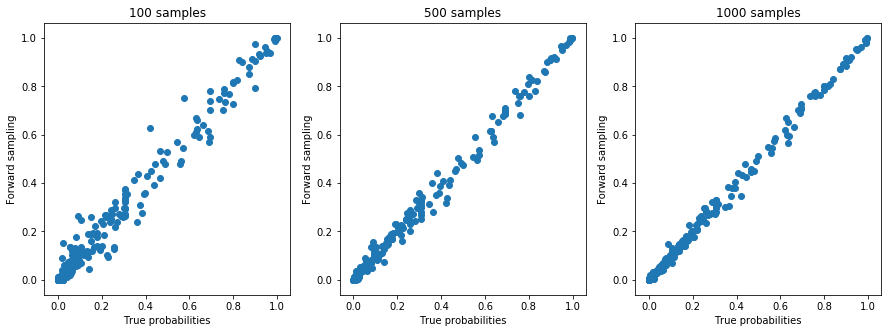

In [36]:
random.seed(0)
queries = query_generator_posterior_marginal(300, ICU_factors, ICU_outcomespace)
x = [q['prob'] for q in queries]
y = [likelihood_weighting(ICU_graph, ICU_factors, q['query'], q['evidence'], 100, ICU_outcomespace)[0] for q in queries]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
y = [likelihood_weighting(ICU_graph, ICU_factors, q['query'], q['evidence'], 500, ICU_outcomespace)[0] for q in queries]
plt.subplot(1,3,2)
plt.scatter(x, y)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
y = [likelihood_weighting(ICU_graph, ICU_factors, q['query'], q['evidence'], 1000, ICU_outcomespace)[0] for q in queries]
plt.subplot(1,3,3)
plt.scatter(x, y)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")    
plt.show()

Great! Likelihood weighting is a lot better than rejection sampling. That explains why this technique is so popular and used in several tasks such as robot mapping as we have seen in the lectures.

We can make a similar analysis we did with rejection sampling and check if the worst estimates are associated with small weights.

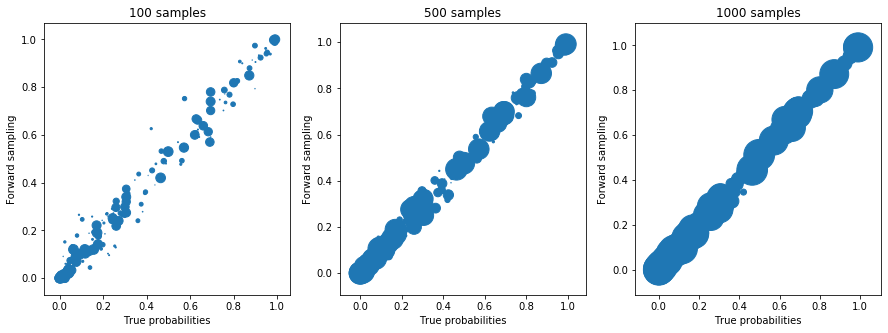

In [37]:
random.seed(0)
queries = query_generator_posterior_marginal(300, ICU_factors, ICU_outcomespace)
x = [q['prob'] for q in queries]
r = [likelihood_weighting(ICU_graph, ICU_factors, q['query'], q['evidence'], 100, ICU_outcomespace) for q in queries]
y = [x[0] for x in r]
w = [x[1]+.1 for x in r]                                   # Don't let the zero weight estimates disapper in the plot
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y, s = w)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
r = [likelihood_weighting(ICU_graph, ICU_factors, q['query'], q['evidence'], 500, ICU_outcomespace) for q in queries]
y = [x[0] for x in r]
w = [x[1]+.1 for x in r]                                   # Don't let the zero weight estimates disapper in the plot
plt.subplot(1,3,2)
plt.scatter(x, y, s = w)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")
r = [likelihood_weighting(ICU_graph, ICU_factors, q['query'], q['evidence'], 1000, ICU_outcomespace) for q in queries]
y = [x[0] for x in r]
w = [x[1]+.1 for x in r]                                   # Don't let the zero weight estimates disapper in the plot
plt.subplot(1,3,3)
plt.scatter(x, y, s = w)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Likelihood weighting")    
plt.show()

# Gibbs sampling

Gibbs sampling is an algorithm based on Markov chains. The basic idea is that we can create a transition matrix that has as a stationary distribution the distribution induced by the Bayesian or Markov network. If we simulate this chain long enough, we can sample from the chain as if we were sampling from the underlying distribution induced by the network.

Gibbs sampling implementation is much more complex than the previous methods. To be an efficient method, we need to implement the inference for the transition matrix carefully.

In particular, such inference will involve a reduced number of factors. When sampling a variable $X$ we will need to have access to all factors that mention $X$.

We start by creating a graph that we call the *Gibbs graph*. In this graph, a node $X$ has a direct edge to all nodes $Y_i$ in which $X$ appears in the factor associated with $Y_i$.

## Exercise

Implement the `gibbs_graph` function that takes as input a set of factors and outputs a Gibbs graph.

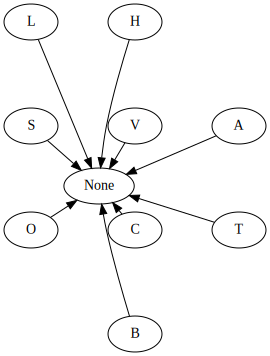

In [38]:
def gibbs_graph(factors, outcomeSpace):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns an adjacency list representation of the Gibbs graph
    """        
    # Initialize representation that is a dictionary of node ids
    gg = {}
    # Initialize each adjacency list with an empty list
    for var in outcomeSpace.keys():
        gg[var] = []
    for f_id in factors.keys():
        for var in factors[f_id]['dom']:
            # Connect node var to f_id by appending f_id in the adjaceny list of var
            gg[var].append(None)                                                           # 1 line
    return gg


##############
# Test code

gg = gibbs_graph(ICU_factors, ICU_outcomespace)
dot = Digraph(engine="neato", comment='Interaction graph example', strict=True)
dot.attr(overlap="false", splines="true")

# List of positions for each node
# We use node positions to replicate the previous figure
# This can be removed if the nodes do not need to be presented in a specific order
pos = {
    'B': '1,0!',
    'O': '0,1!',
    'C': '1,1!',
    'T': '2,1!',
    'S': '0,2!',
    'V': '1,2!',
    'A': '2,2!',
    'L': '0,3!',
    'H': '1,3!',
}

for v in gg.keys():
    dot.node(str(v), pos=pos[v])
    # dot.node(str(v))              # Use this line instead of the previous one to position the nodes in random order

for v in gg.keys():
    for w in gg[v]:
        dot.edge(str(v), str(w))

dot

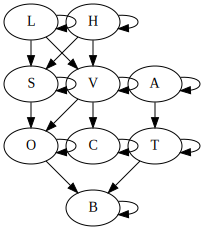

In [39]:
# Answer

def gibbs_graph(factors, outcomeSpace):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns an adjacency list representation of the Gibbs graph
    """        
    # Initialize representation that is a dictionary of node ids
    gg = {}
    # Initialize each adjacency list with an empty list
    for var in outcomeSpace.keys():
        gg[var] = []
    for f_id in factors.keys():
        for var in factors[f_id]['dom']:
            # Connect node var to f_id by appending f_id in the adjaceny list of var
            gg[var].append(f_id)
    return gg


##############
# Test code

gg = gibbs_graph(ICU_factors, ICU_outcomespace)
dot = Digraph(engine="neato", comment='Interaction graph example', strict=True)
dot.attr(overlap="false", splines="true")

# List of positions for each node
# We use node positions to replicate the previous figure
# This can be removed if the nodes do not need to be presented in a specific order
pos = {
    'B': '1,0!',
    'O': '0,1!',
    'C': '1,1!',
    'T': '2,1!',
    'S': '0,2!',
    'V': '1,2!',
    'A': '2,2!',
    'L': '0,3!',
    'H': '1,3!',
}

for v in gg.keys():
    dot.node(str(v), pos=pos[v])
    # dot.node(str(v))              # Use this line instead of the previous one to position the nodes in random order

for v in gg.keys():
    for w in gg[v]:
        dot.edge(str(v), str(w))

dot

If your output is correct, you should generate the following graph.

![Gibbs graph](img/GG.png)

The Gibbs graph tells us that the factors that mention, for example, $H$ are in nodes $H$, $S$ and $V$. Therefore, we will need to multiply these factors to sample the variable $H$.

Before we implement the Gibbs transition, we need to remember that Markov chain Monte Carlo (MCMC) methods work with complete assignments. We will need a helper function that creates a complete assignment.

In [40]:
def complete_assignment(factors, outcomeSpace, exclude = []):
    return { v : random.choice(outcomeSpace[v]) for v in outcomeSpace.keys() if v not in exclude}


#####################
# Test code

random.seed(0)
alpha = complete_assignment(ICU_factors, ICU_outcomespace)
print(alpha)

{'H': 1, 'L': 1, 'A': 0, 'V': 1, 'S': 1, 'T': 1, 'C': 1, 'O': 1, 'B': 1}


Now, we will implement the `gibbs_transition` function. In some sense, it is similar to simulating the network. The main differences are:

1. We will work with complete assignments, instead of building one from scratch. 
2. There is no need to traverse the network in any specific order.
3. Each time we sample a variable, we will choose the variable randomly from the set of all non-evidence variables in the network.
4. The sampling process will involve an inference step. The previous sampling methods we discussed were more straightforward since we used conditional probabilities already available in the network parameters.

The main challenge is to implement the inference step efficiently. We will use the Gibbs graph to help us to identify the relevant factors correctly.

## Exercise

Implement the `gibbs_transition` function. This function takes an assignment sigma as input, chooses one variable randomly with uniform distribution and sample a new value for this variable according to the Gibbs transition.

In [68]:
def gibbs_transition(factors, GG, sigma, beta, outcomeSpace):
    """
    argument
    `factors`: a dictionary will all netowrk factors
    `GG`: an adjacency list representation of the Gibbs graph
    `sigma`: a dictionary representing a complete assignment of all variables
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    output: `sigma` modified with one variable resampled according to the Gibbs transition probabilities
    """
    # These are the non-evidence variables in the network. We will sample from this list
    not_ev_vars = [v for v in outcomeSpace.keys() if v not in beta.keys()]
    # Randomly sample one variable with uniform distribution
    X = random.choice(not_ev_vars)
    # Create an empty factor that we will use to store our inference results
    gibbs_factor = {'dom': list(X), 'table': odict({(v,): 1 for v in outcomeSpace[X]})}
    for value in outcomeSpace[X]:
        # Let's use the Gibbs graph to see which factors we need to multiply
        for var in GG[X]:
            # IMPORTANT: instead of call join and multiply all factors, we will only multiply the entries compatible with evidence
            # Remember we are working with complete assignments. See the lecture about classification with graphical models for details
            
            # Assign a value to variable X in sigma
            sigma[X] = value
            # Compute the entry to retrieve the probability 
            entry = (sigma[v] for v in factors[var]['dom'])
            # Multiply the probabilities in the relevant factors (factors[var] is the relevant factor)
            gibbs_factor['table'][(value,)] *= None

    # Renormalize the gibbs_factor, so we probabilities sum to one and we can sample a value for X
    gibbs_factor = None                                                                     # 1 line
    # Call sample_variable to sample a value for X according to the distribution in gibbs_factor
    None # 1 line
    return sigma

    
##################
# Test code

random.seed(6)
gg = gibbs_graph(ICU_factors, ICU_outcomespace)
beta = random_assignment(ICU_factors, ICU_outcomespace, 3)
alpha = complete_assignment(ICU_factors, ICU_outcomespace, beta)
alpha.update(beta)
print(alpha)
new_alpha = gibbs_transition(ICU_factors, gg, alpha, beta, ICU_outcomespace)
print(new_alpha)

{'H': 0, 'A': 1, 'V': 1, 'S': 1, 'T': 0, 'B': 1, 'L': 1, 'O': 0, 'C': 0}


TypeError: unsupported operand type(s) for *=: 'int' and 'NoneType'

In [69]:
# Answer

def gibbs_transition(factors, GG, sigma, beta, outcomeSpace):
    """
    argument
    `factors`: a dictionary will all netowrk factors
    `GG`: an adjacency list representation of the Gibbs graph
    `sigma`: a dictionary representing a complete assignment of all variables
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    output: `sigma` modified with one variable resampled according to the Gibbs transition probabilities
    """
    # These are the non-evidence variables in the network. We will sample from this list
    not_ev_vars = [v for v in outcomeSpace.keys() if v not in beta.keys()]
    # Randomly sample one variable with uniform distribution
    X = random.choice(not_ev_vars)
    # Create an empty factor that we will use to store our inference results
    gibbs_factor = {'dom': list(X), 'table': odict({(v,): 1 for v in outcomeSpace[X]})}
    for value in outcomeSpace[X]:
        # Let's use the Gibbs graph to see which factors we need to multiply
        for var in GG[X]:
            # IMPORTANT: instead of call join and multiply all factors, we will only multiply the entries compatible with evidence
            # Remember we are working with complete assignments. See the lecture about classification with graphical models for details
            
            # Assign a value to variable X in sigma
            sigma[X] = value
            # Compute the entry to retrieve the probability 
            entry = (sigma[v] for v in factors[var]['dom'])
            # Multiply the probabilities in the relevant factors
            gibbs_factor['table'][(value,)] *= prob(factors[var], *entry)
    # Renormalize the gibbs_factor, so we probabilities sum to one and we can sample a value for X
    gibbs_factor = normalize(gibbs_factor)
    # Call sample_variable to sample a value for X according to the distribution in gibbs_factor
    sigma = sample_variable(X, gibbs_factor, sigma, outcomeSpace)
    return sigma

    
##################
# Test code

random.seed(6)
gg = gibbs_graph(ICU_factors, ICU_outcomespace)
beta = random_assignment(ICU_factors, ICU_outcomespace, 3)
alpha = complete_assignment(ICU_factors, ICU_outcomespace, beta)
alpha.update(beta)
print(alpha)
new_alpha = gibbs_transition(ICU_factors, gg, alpha, beta, ICU_outcomespace)
print(new_alpha)

{'H': 0, 'A': 1, 'V': 1, 'S': 1, 'T': 0, 'B': 1, 'L': 1, 'O': 0, 'C': 0}
{'H': 0, 'A': 1, 'V': 1, 'S': 0, 'T': 0, 'B': 1, 'L': 1, 'O': 0, 'C': 0}


If your response is correct, you should see the following output:

```
{'H': 0, 'A': 1, 'V': 1, 'S': 1, 'T': 0, 'B': 1, 'L': 1, 'O': 0, 'C': 0}
{'H': 0, 'A': 1, 'V': 1, 'S': 0, 'T': 0, 'B': 1, 'L': 1, 'O': 0, 'C': 0}
```

Let's now create a function to initialise a certain number of chains. We can use the `simulate_BN_likelihood` to generate a sample that conforms with the evidence. The next procedure will call the `simulate_BN_likelihood` multiple times to create the first state of the Markov chain.

## Exercise

Implement the `create_chains` procedure to create (initialise) a certain number of chains specified in the argument `n_chains`. This function only makes the initial states of the Markov chains. Later, we will use the already implemented `gibbs_transition` to transition the chains.

In [60]:
def create_chains(G, factors, beta, n_chains, outcomeSpace):
    """
    argument
    `G`: an adjacency list representation of the network graph
    `factors`: a dictionary will all netowrk factors
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `n_chains`:  number of chains to be created
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: a list with n_chains assignments created with simulate_BN_likelihood
    """
    # This list start empty and we will add new assignments that will be used as first states of the Markov chains
    sigmas = []
    # Controls the number of chains created so far
    c = 0
    while c < n_chains:
        # Call simulate_BN_likelihood to create one assignment that agrees with beta
        sigma, w = None                                                                      # 1 line
        # Let's discard assigments with zero weights. They may be invalid states if we have deterministic CPTs
        if w > 0:
            # Append the assingment sigma to the list sigmas
            None                                                                             # 1 line
            # Increment our chain count
            c += 1
    return sigmas


################
# Test code

random.seed(0)
beta = random_assignment(ICU_factors, ICU_outcomespace, 3)
create_chains(ICU_graph, ICU_factors, beta, 5, ICU_outcomespace)

TypeError: cannot unpack non-iterable NoneType object

In [70]:
# Answer

def create_chains(G, factors, beta, n_chains, outcomeSpace):
    """
    argument
    `G`: an adjacency list representation of the network graph
    `factors`: a dictionary will all netowrk factors
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `n_chains`:  number of chains to be created
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    return: a list with n_chains assignments created with simulate_BN_likelihood
    """
    # This list start empty and we will add new assignments that will be used as first states of the Markov chains
    sigmas = []
    # Controls the number of chains created so far
    c = 0
    while c < n_chains:
        # Call simulate_BN_likelihood to create one assignment that agrees with beta
        sigma, w = simulate_BN_likelihood(G, factors, beta, outcomeSpace)
        # Let's discard assigments with zero weights. They may be invalid states if we have deterministic CPTs
        if w > 0:
            # Append the assingment sigma to the list sigmas
            sigmas.append(sigma)
            # Increment our chain count
            c += 1
    return sigmas


################
# Test code

random.seed(0)
beta = random_assignment(ICU_factors, ICU_outcomespace, 3)
create_chains(ICU_graph, ICU_factors, beta, 5, ICU_outcomespace)

[{'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 1, 'O': 1, 'B': 1},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 1, 'O': 2, 'B': 2},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 1, 'O': 1, 'B': 1},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 0, 'O': 0, 'B': 0},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 0, 'O': 0, 'B': 1}]

If your code is correct, you should see the following output:

```
[{'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 1, 'O': 1, 'B': 1},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 1, 'O': 2, 'B': 2},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 1, 'O': 1, 'B': 1},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 0, 'O': 0, 'B': 0},
 {'A': 0, 'T': 1, 'H': 1, 'L': 0, 'V': 0, 'C': 1, 'S': 0, 'O': 0, 'B': 1}]
```

Finally, we implement the functions `gibbs_sampling`. This function has two unique arguments. The first, `n_burnin`, is the number of transitions we apply to the chain before we start sampling. This period is known as burn-in. The second, `n_steps`, is the number of transitions we apply to the chain between two consecutive samples. `n_steps` help us to obtain samples that are less correlated between each other.

## Exercise

Let's implement `gibbs_sampling`. We prepared a stub for you. You need to fill in the gaps.

In [63]:
def gibbs_sampling(G, factors, alpha, beta, n_chains, n_samples, outcomeSpace, n_burnin = 1000, n_steps = 1):
    """
    argument
    `G`: an adjacency list representation of the network graph
    `factors`: a dictionary will all netowrk factors
    `alpha`:  a dictionary that represents an assignment for all network variables
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `n_chains`:  number of chains to be created
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    `n_burnin`: number of burn-in steps
    `n_steps`: number of steps (transitions) between two consecutive samples
    return: an estimate of P(alpha|beta) according Gibbs sampling
    """
    # Number of samples that match the alpha and beta assignments
    p = 0
    # Create a Gibbs graph and assign to gg
    gg = None                                                                              # 1 line
    # Create n_chains initial assignments to be used as first states of the Markov chains
    states = None                                                                          # 1 line
    
    ########### Start of the Burn-in phase ###########
    for i in range(n_burnin):
        for c in range(n_chains):
            # Call gibbs_transition to transit in each of the chains. Pass states[c] as alpha
            None                                                                          # 1 line
    ############ End of the Burn-in phase ############
    
    # Now we are going to start sampling
    for i in range(n_samples):
        for c in range(n_chains):
            for s in range(n_steps):
                # Call gibbs_transition to transit in each of the chains. Pass states[c] as alpha
                None                                                                      # 1 line
            # Check if the new samples matches alpha
            if (all(v == states[c][k] for k, v in alpha.items())):
                p += 1
    return p/(n_samples*n_chains)

#######################
# Test code

random.seed(0)
p = gibbs_sampling(ICU_graph, ICU_factors, {'T':0}, {'A': 0}, 10, 1000, ICU_outcomespace)
print("P(A=0|T=0)=", p)

TypeError: 'NoneType' object is not subscriptable

In [72]:
# Answer
def gibbs_sampling(G, factors, alpha, beta, n_chains, n_samples, outcomeSpace, n_burnin = 1000, n_steps = 1):
    """
    argument
    `G`: an adjacency list representation of the network graph
    `factors`: a dictionary will all netowrk factors
    `alpha`:  a dictionary that represents an assignment for all network variables
    `beta`:  a dictionary that represents an assignment for all evidence variables
    `n_chains`:  number of chains to be created
    `outcomeSpace`: dictionary with variables names and corresponding valid values
    `n_burnin`: number of burn-in steps
    `n_steps`: number of steps (transitions) between two consecutive samples
    return: an estimate of P(alpha|beta) according Gibbs sampling
    """
    # Number of samples that match the alpha and beta assignments
    p = 0
    # Create a Gibbs graph and assign to gg
    gg = gibbs_graph(factors, outcomeSpace)
    # Create n_chains initial assignments to be used as first states of the Markov chains
    states = create_chains(G, factors, beta, n_chains, outcomeSpace)
    
    ########### Start of the Burn-in phase ###########
    for i in range(n_burnin):
        for c in range(n_chains):
            # Call gibbs_transition to transit in each of the chains. Pass states[c] as alpha
            states[c] = gibbs_transition(factors, gg, states[c], beta, outcomeSpace)
    ############ End of the Burn-in phase ############
    
    # Now we are going to start sampling
    for i in range(n_samples):
        for c in range(n_chains):
            for s in range(n_steps):
                # Call gibbs_transition to transit in each of the chains. Pass states[c] as alpha
                states[c] = gibbs_transition(factors, gg, states[c], beta, outcomeSpace)
            # Check if the new samples matches alpha
            if (all(v == states[c][k] for k, v in alpha.items())):
                p += 1
    return p/(n_samples*n_chains)

#######################
# Test code

random.seed(0)
p = gibbs_sampling(ICU_graph, ICU_factors, {'T':0}, {'A': 0}, 10, 1000, ICU_outcomespace)
print("P(A=0|T=0)=", p)

P(A=0|T=0)= 0.3411


If your code is correct, you should see the following output:

```
P(A=0|T=0)= 0.3411
```

Now, let's compare Gibbs sampling with the remaining sampling methods. To make things a little more comparable, we will use a single chain. Our burn-in period will be 1,000 samples, and we will sample every 100 chain transitions.

The next cell should take a few minutes to complete.

In [ ]:
random.seed(0)
queries = query_generator_posterior_marginal(300, ICU_factors, ICU_outcomespace)
x = [q['prob'] for q in queries]
y = [gibbs_sampling(ICU_graph, ICU_factors, q['query'], q['evidence'], 1, 100, ICU_outcomespace, 1000, 100) for q in queries]
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.scatter(x, y)
plt.title("100 samples")
plt.xlabel("True probabilities")
plt.ylabel("Gibbs sampling")
y = [gibbs_sampling(ICU_graph, ICU_factors, q['query'], q['evidence'], 1, 500, ICU_outcomespace, 1000, 100) for q in queries]
plt.subplot(1,3,2)
plt.scatter(x, y)
plt.title("500 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Gibbs sampling")
y = [gibbs_sampling(ICU_graph, ICU_factors, q['query'], q['evidence'], 1, 1000, ICU_outcomespace, 1000, 100) for q in queries]
plt.subplot(1,3,3)
plt.scatter(x, y)
plt.title("1000 samples")    
plt.xlabel("True probabilities")
plt.ylabel("Gibbs sampling")    
plt.show()

Great. It seems that Gibbs sampling can provide competitive results if compared to likelihood sampling. However, Gibbs sampling is significatively more demanding. 

We have worked with a simple network. In more complex ones, likelihood sampling may have issues and end up generating samples with small weights. In this case, Gibbs sampling may perform better.

That is all for today. We have reached the end of week 10. It was good to have you with us!